# DECISION TREE CODE BASED ON GINI INDEX

In [ ]:
import numpy as np
import pandas as pd
import random
from pprint import pprint

In [ ]:
df = pd.read_csv('heart.csv')
df.shape

(303, 14)

In [ ]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


#### Split training and testing data

In [ ]:
def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))
    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)
    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

In [ ]:
random.seed(100)
train_df, test_df = train_test_split(df, test_size=30)

In [ ]:
data = train_df.values

#### Check for unique class

In [ ]:
def check_purity(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

In [ ]:
def classify_data(data):
    
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

#### Potential splits

In [ ]:
def get_potential_splits(data):
    
    potential_splits = {}
    _, n_columns = data.shape
    for column_idx in range(n_columns - 1):        
        potential_splits[column_idx] = []
        values = data[:, column_idx]
        unique_values = np.unique(values)

        for i in range(len(unique_values)):
            if i != 0:
                current_value = unique_values[i]
                previous_value = unique_values[i - 1]
                potential_split = (current_value + previous_value) / 2
                
                potential_splits[column_idx].append(potential_split)
    
    return potential_splits

In [ ]:
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    data_below = data[split_column_values <= split_value]
    data_above = data[split_column_values >  split_value]
    
    return data_below, data_above

#### gini index calculation

In [ ]:
def calculate_gini(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    gini = 1 - sum(probabilities**2)
     
    return gini

In [ ]:
#calculate overall informaton gain for the splits 
def calculate_overall_gini(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_gini =  (p_data_below * calculate_gini(data_below) + p_data_above * calculate_gini(data_above))
    
    return overall_gini

#### Best split 

In [ ]:
def determine_best_split(data, potential_splits):
    
    overall_gini = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_gini = calculate_overall_gini(data_below, data_above)

            if current_overall_gini <= overall_gini:
                overall_gini = current_overall_gini
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

In [ ]:
sub_tree = {"question": ["yes_answer", 
                         "no_answer"]}

#### Algorithm

In [ ]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=3):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # sub-tree
        feature_name = COLUMN_HEADERS[split_column]
        question = "{} <= {}".format(feature_name, split_value)
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)
        
    
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

In [ ]:
tree = decision_tree_algorithm(train_df, max_depth=3)
pprint(tree)

{'cp <= 0.5': [{'ca <= 0.5': [{'thal <= 2.5': [1.0, 0.0]}, 0.0]},
               {'age <= 56.5': [1.0, {'sex <= 0.5': [1.0, 0.0]}]}]}


In [ ]:
sub_tree

{'question': ['yes_answer', 'no_answer']}

In [ ]:
example = test_df.iloc[0]
example

age          43.0
sex           0.0
cp            2.0
trestbps    122.0
chol        213.0
fbs           0.0
restecg       1.0
thalach     165.0
exang         0.0
oldpeak       0.2
slope         1.0
ca            0.0
thal          2.0
target        1.0
Name: 74, dtype: float64

#### Classification

In [ ]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split()

    # ask question
    if example[feature_name] <= float(value):
        answer = tree[question][0]
    else:
        answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [ ]:
classify_example(example, tree)

1.0

#### Accuracy

In [ ]:
def calculate_accuracy(df, tree):

    df["classification"] = df.apply(classify_example, axis=1, args=(tree,))
    df["classification_correct"] = df["classification"] == df["target"]
    
    accuracy = df["classification_correct"].mean()
    
    return accuracy

In [ ]:
accuracy_gini = calculate_accuracy(test_df, tree)
accuracy_gini

0.8333333333333334

# decision tree classifier using sklearn

In [ ]:
df = pd.read_csv('heart.csv')
df.shape

(303, 14)

In [ ]:
label = df['target']
feature_cols = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']
df.drop(['target'], axis = 1, inplace = True)
df = df.values
samples,features = df.shape
print(samples,features)

303 13


In [ ]:
data = df.astype(np.float)
data.shape

(303, 13)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3,random_state=100)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
clf = DecisionTreeClassifier(criterion='gini', max_depth=3,min_samples_split=2)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [ ]:
Accuracy_decisiontreeSKLEARN = metrics.accuracy_score(y_test, y_pred)
Accuracy_decisiontreeSKLEARN

0.8351648351648352

# Logistic regression classifier using sklearn

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logisticRegr = LogisticRegression(max_iter=1000)
clf = logisticRegr.fit(X_train, y_train)
y_pred = logisticRegr.predict(X_test)

In [ ]:
Accuracy_logisticregressionSKLEARN = metrics.accuracy_score(y_test, y_pred)
Accuracy_logisticregressionSKLEARN

0.8571428571428571

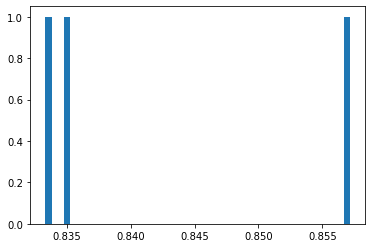

  gini  decisiontree       logisticregression
  0.833    0.83516           0.85714


In [ ]:
import matplotlib.pyplot as plt

x =[accuracy_gini,Accuracy_decisiontreeSKLEARN,Accuracy_logisticregressionSKLEARN]
plt.hist(x,bins=50)
plt.show()
print('  gini  decisiontree       logisticregression')
print("  0.833    0.83516           0.85714")

### CONCLUSION
Our Decision tree model using gini index gives accuracy closer to that by SKLEARN.